# **Tacotron2 CPU Synthesizer**

  Cloning https://github.com/IAHispano/gdown.git to /tmp/pip-req-build-b916sq4d
  Running command git clone --filter=blob:none --quiet https://github.com/IAHispano/gdown.git /tmp/pip-req-build-b916sq4d
  Resolved https://github.com/IAHispano/gdown.git to commit 6f0bd9df3f33edc7024e55088118ddbab5ef3a27
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using universal Hifi-Gan model.
Current Config:
pronounciation_dictionary: False
show_graphs: True
max_duration (in seconds): 20
stop_threshold: 0.5
superres_strength: 5


Enter/Paste your text.
--------------------------------------------------
Hi children hope you are stoned as hell


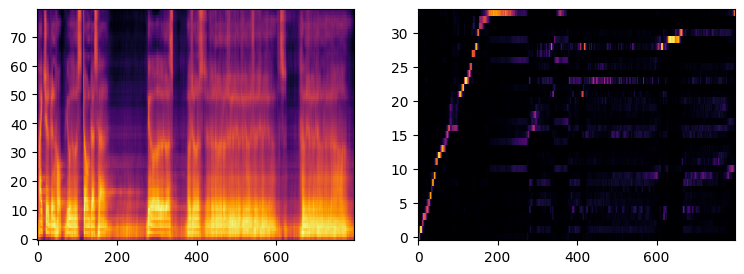

--------------------------------------------------
Stopping...


In [2]:
#prep
import os
!pip install tqdm -q
from tqdm.notebook import tqdm
from IPython.display import clear_output
from os.path import exists, join, basename, splitext
!pip install resampy
!pip install git+https://github.com/IAHispano/gdown.git
git_repo_url = 'https://github.com/justinjohn0306/TTS-TT2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
# clone and install
  !git clone -q --recursive {git_repo_url}
  !git clone -q --recursive https://github.com/justinjohn0306/hifi-gan
  !pip install -q unidecode
import sys
sys.path.append('hifi-gan')
sys.path.append(project_name)


import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)


#Universal HiFi-GAN (has some robotic noise): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW

#@markdown ---


#@markdown **The "tacotron_id" is where you can put a link to your trained tacotron2 model from Google Drive.**


#@markdown If the audio sounds too artificial, you can lower the superres_strength

#@markdown ---
#@markdown Config:

#@markdown Restart the runtime to apply any changes.

tacotron_id = "1HWEo__LkEZx28GdDEy60wtUeb3r_nYLK" #@param {type:"string"}

hifigan_id = "universal" #@param {type:"string"}

#@markdown _leave blank or enter "universal" for universal model_

#@markdown ---

if tacotron_id != "":
    TACOTRON2_ID = tacotron_id
else:
    raise Exception("No ID provided.")

if hifigan_id in {"", "universal"}:
    HIFIGAN_ID = "universal"
    print("Using universal Hifi-Gan model.")
else:
    HIFIGAN_ID = hifigan_id

# Check if Initialized
try:
    initialized
except NameError:
    print("Setting up, please wait.\n")
    with tqdm(total=5, leave=False) as pbar:

        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from hparams import create_hparams
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import mel_spectrogram, MAX_WAV_VALUE
        from models import Generator
        from denoiser import Denoiser
        import resampy
        import scipy.signal

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='lower',
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        !wget 'https://github.com/justinjohn0306/FakeYou-Tacotron2-Notebook/releases/download/CMU_dict/merged.dict.txt'
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID, conf_name):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel_' + conf_name
            #gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)

            if MODEL_ID == 1:
              !wget "https://github.com/justinjohn0306/tacotron2/releases/download/assets/Superres_Twilight_33000" -O $hifigan_pretrained_model
            elif MODEL_ID == "universal":
              !wget "https://github.com/justinjohn0306/tacotron2/releases/download/assets/g_02500000" -O $hifigan_pretrained_model
            else:
              gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)

            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", conf_name + ".json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cpu"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cpu"))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            denoiser = Denoiser(hifigan, mode="normal")
            return hifigan, h, denoiser

        # Download character HiFi-GAN
        hifigan, h, denoiser = get_hifigan(HIFIGAN_ID, "config_v1")
        # Download super-resolution HiFi-GAN
        hifigan_sr, h2, denoiser_sr = get_hifigan(1, "config_32k")
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = 'MLPTTS'
            gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams = create_hparams()
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            state_dict = torch.load(tacotron2_pretrained_model, map_location=torch.device("cpu"))['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.eval()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text, pronounciation_dictionary, show_graphs):
            for i in [x for x in text.split("\n") if len(x)]:
                if not pronounciation_dictionary:
                    if i[-1] != ";": i=i+";"
                else: i = ARPA(i)
                with torch.no_grad(): # save VRAM by not including gradients
                    sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
                    if show_graphs:
                        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                                alignments.float().data.cpu().numpy()[0].T))
                    y_g_hat = hifigan(mel_outputs_postnet.float())
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    audio_denoised = denoiser(audio.view(1, -1), strength=35)[:, 0]

                    # Resample to 32k
                    audio_denoised = audio_denoised.cpu().numpy().reshape(-1)

                    normalize = (MAX_WAV_VALUE / np.max(np.abs(audio_denoised))) ** 0.9
                    audio_denoised = audio_denoised * normalize
                    wave = resampy.resample(
                        audio_denoised,
                        h.sampling_rate,
                        h2.sampling_rate,
                        filter="sinc_window",
                        window=scipy.signal.windows.hann,
                        num_zeros=8,
                    )
                    wave_out = wave.astype(np.int16)

                    # HiFi-GAN super-resolution
                    wave = wave / MAX_WAV_VALUE
                    wave = torch.FloatTensor(wave).to(torch.device("cpu"))
                    new_mel = mel_spectrogram(
                        wave.unsqueeze(0),
                        h2.n_fft,
                        h2.num_mels,
                        h2.sampling_rate,
                        h2.hop_size,
                        h2.win_size,
                        h2.fmin,
                        h2.fmax,
                    )
                    y_g_hat2 = hifigan_sr(new_mel)
                    audio2 = y_g_hat2.squeeze()
                    audio2 = audio2 * MAX_WAV_VALUE
                    audio2_denoised = denoiser(audio2.view(1, -1), strength=35)[:, 0]

                    # High-pass filter, mixing and denormalizing
                    audio2_denoised = audio2_denoised.cpu().numpy().reshape(-1)
                    b = scipy.signal.firwin(
                        101, cutoff=10500, fs=h2.sampling_rate, pass_zero=False
                    )
                    y = scipy.signal.lfilter(b, [1.0], audio2_denoised)
                    y *= superres_strength
                    y_out = y.astype(np.int16)
                    y_padded = np.zeros(wave_out.shape)
                    y_padded[: y_out.shape[0]] = y_out
                    sr_mix = wave_out + y_padded
                    sr_mix = sr_mix / normalize

                    print("")
                    ipd.display(ipd.Audio(sr_mix.astype(np.int16), rate=h2.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initialized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h, denoiser = get_hifigan(HIFIGAN_ID, "config_v1")
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration =  20#@param {type:"integer"}
model.decoder.max_decoder_steps = max_duration * 80
stop_threshold = 0.5 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold
superres_strength = 5 #@param {type:"number"}

print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\nsuperres_strength: {superres_strength}\n\n")

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line, not pronounciation_dictionary, show_graphs)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break